# Machine Learning Lifecycle Example

## 1. Define Objective

**Objective:** Infer how IQ, Years Experience, and Age affects income using a linear model.

## 2. Collect Data

In [1]:
import tensorflow as tf
import numpy as np

import pandas as pd
from pandas import DataFrame as DF

In [2]:
# create dataset
np.random.seed(555)
X1 = np.random.normal(100, 15, 200).astype(int)
X2 = np.random.normal(10, 4.5, 200)
X3 = np.random.normal(32, 4, 200).astype(int)
dob = np.datetime64('2017-10-31') - 365*X3
b = 5
er = np.random.normal(0, 1.5, 200)

Y = np.array([0.3*x1 + 1.5*x2 + 0.83*x3 + b + e for x1,x2,x3,e in zip(X1,X2,X3,er)])

## 3. Data Cleaning

In [3]:
cols = ['iq','years_experience','dob']
df = DF(list(zip(X1,X2,dob)), columns=cols)
df['income'] = Y
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
iq                  200 non-null int64
years_experience    200 non-null float64
dob                 200 non-null datetime64[ns]
income              200 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 6.3 KB


In [4]:
df.describe()

,iq,years_experience,income
count,200.000000,200.000000,200.000000
mean,98.895000,9.708405,75.177962
std,14.991253,4.654536,8.889551
min,62.000000,-5.789565,49.467100
25%,88.500000,6.603565,69.391361
50%,99.000000,10.021919,75.180707
75%,108.250000,12.927809,80.739804
max,134.000000,21.889216,98.380710


In [5]:
df = df[df.years_experience >= 0]
df.describe()

,iq,years_experience,income
count,196.000000,196.000000,196.000000
mean,98.959184,9.963718,75.603845
std,14.769628,4.332578,8.424493
min,62.000000,0.084480,54.325402
25%,88.500000,6.940314,69.619532
50%,99.000000,10.192384,75.327426
75%,108.250000,12.967590,80.798796
max,134.000000,21.889216,98.380710


## 4. EDA

In [6]:
df.describe(include=['datetime64'])

,dob
count,196
unique,22
top,1986-11-08 00:00:00
freq,20
first,1975-11-11 00:00:00
last,1996-11-05 00:00:00


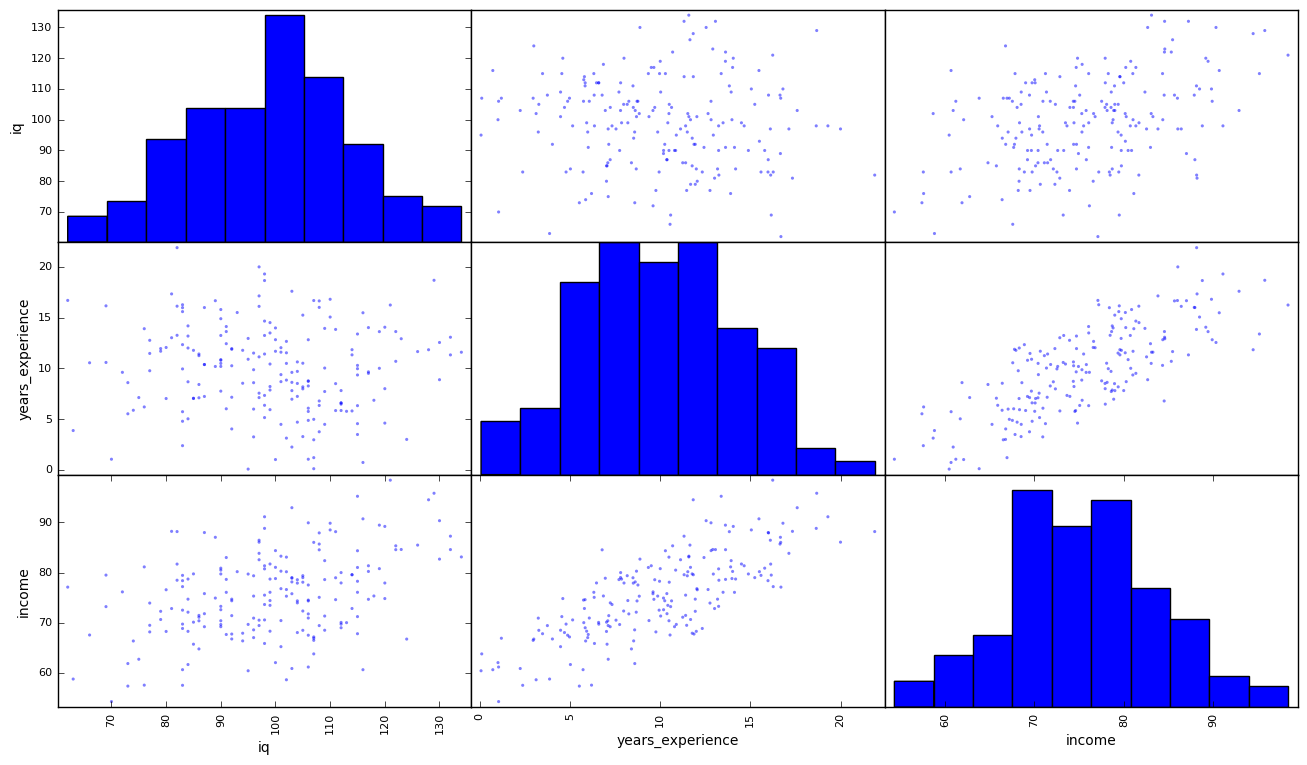

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

pd.plotting.scatter_matrix(df, figsize=(16,9));

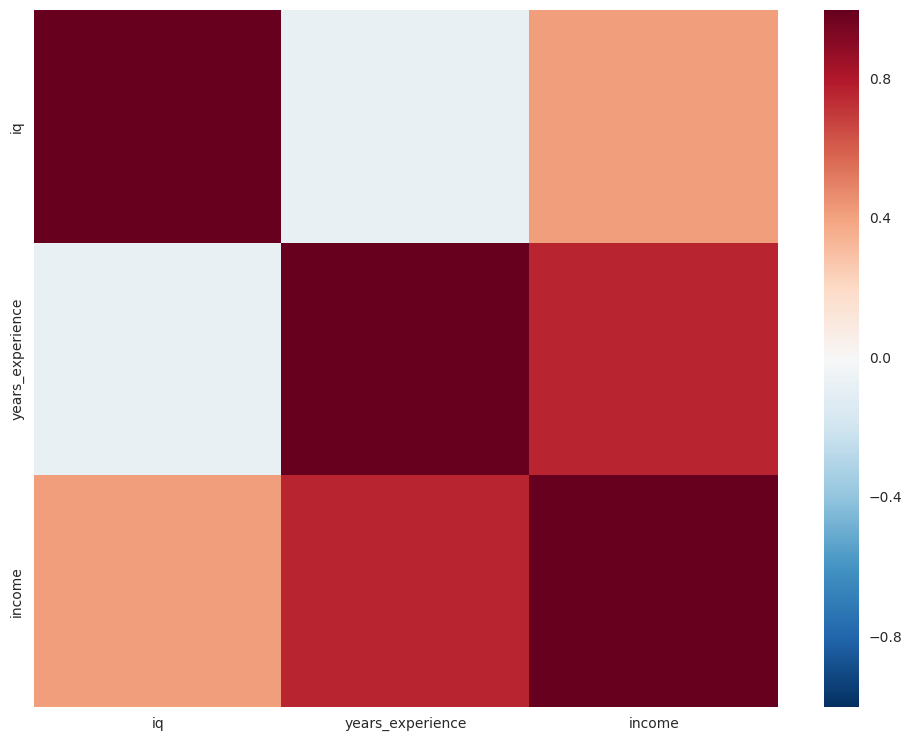

In [8]:
import seaborn as sns
plt.figure(figsize=(12,9))
sns.heatmap(df.corr());

## 5. Data Processing / Feature Engineering

In [9]:
from datetime import datetime as dt

df['age'] = df.dob.apply(lambda x: (dt.strptime('2017-10-31', '%Y-%m-%d') - x).days/365)
df.drop('dob', axis=1, inplace=True)
df.head()

,iq,years_experience,income,age
0,102,3.134666,58.665854,23.0
1,105,15.245371,78.989823,25.0
2,83,2.391084,57.564307,29.0
3,103,9.606721,75.783867,33.0
4,97,11.134619,82.547093,36.0


## 6. Train/Evaluate Models

In [10]:
import tensorflow as tf

In [18]:
# train/test split
X = df.iloc[:, [0,1,3]]
Y = df.income

tr_idx = X.sample(frac=0.67).index
Xtr = X[X.index.isin(tr_idx)].values
Xts = X[~X.index.isin(tr_idx)].values

Ytr = Y[Y.index.isin(tr_idx)].values
Yts = Y[~Y.index.isin(tr_idx)].values

### Create Model

In [19]:
tf.reset_default_graph()

In [20]:
sess = tf.Session()

# create parameters
w = tf.get_variable(name='w', initializer=[[0.1], [0.1], [0.1]])
b = tf.get_variable(name='b', initializer=0.)

# create input placeholders
x = tf.placeholder('float32', name='x')
y = tf.placeholder('float32', name='y_true')

# create linear model
yhat = tf.reshape(tf.matmul(x,w) + b, [-1,], name='yhat')

### Create the loss and test score functions

In [21]:
mse = tf.reduce_mean(tf.square(y - yhat), name='mse')
rmse = tf.sqrt(mse, name='rmse')

# test score
test_nrmse = tf.divide(rmse, tf.abs(tf.reduce_mean(y)), name='nrmse')

In [22]:
# init vars
init = tf.variables_initializer([w, b])
sess.run(init)

### Training/Evaluation

In [23]:
# reset parameters w and b
sess.run(init)

# run optimization again with smaller learning rate
opt = tf.train.GradientDescentOptimizer(learning_rate=0.001)
train = opt.minimize(rmse)

for i in range(800):
    if (i%50 == 0) & (i > 0):
        nrmse = sess.run(test_nrmse, {x: Xts, y: Yts})
        print('Test NRMSE: {}'.format(nrmse))
    else:
        sess.run(train, {x: Xtr, y: Ytr})

Test NRMSE: 0.0889994353055954
Test NRMSE: 0.06890401244163513
Test NRMSE: 0.051483720541000366
Test NRMSE: 0.07108651101589203
Test NRMSE: 0.07138531655073166
Test NRMSE: 0.07273358851671219
Test NRMSE: 0.07198677957057953
Test NRMSE: 0.07350262254476547
Test NRMSE: 0.07218547910451889
Test NRMSE: 0.07393982261419296
Test NRMSE: 0.0722532644867897
Test NRMSE: 0.0742126852273941
Test NRMSE: 0.07227297127246857
Test NRMSE: 0.07439125329256058
Test NRMSE: 0.07227432727813721


In [16]:
# 0.3*x1 + 1.5*x2 + 0.83*x3 + 5

In [24]:
sess.run([w,b])

[array([[ 0.27085441],
        [ 1.46122658],
        [ 0.91215396]], dtype=float32), 0.027457662]